In [9]:
import pandas as pd 
import tweepy

In [10]:
# Leer llaves
keys = pd.read_csv("../keys.csv", header=None)
keys = dict(zip(keys[0],keys[1]))

In [11]:
# Autorizar a través API
auth = tweepy.OAuthHandler(keys['api_key'], keys['api_key_secret'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [12]:
tweets = tweepy.Cursor(api.search,
                       q=['miss colombia -RT'],
                       lang='es',
                       tweet_mode='extended',
                       since_id=1328469481430118401,
                       include_rts=False).items(10000)

In [13]:
t = []

for tweet in tweets:
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
    temp.append(tweet.user.location)
    temp.append(tweet.id)
    temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
    
    t.append(temp)

In [14]:
data = pd.DataFrame(t)
data.columns = ['tweet', 'date', 'user_location', 'id', 'link']
data.head()

,tweet,date,user_location,id,link
0,"Ya en Colombia, cualquiera es Técnico de Fútbo...",2020-11-17 13:59:01,"Valledupar, Colombia",1328699166252478464,https://twitter.com/i/web/status/1328699166252...
1,"Quién es Laura Olascuaga, la nueva Miss Colomb...",2020-11-17 13:58:32,,1328699041790701568,https://twitter.com/i/web/status/1328699041790...
2,"El concurso del día de ayer, pertenecía a la e...",2020-11-17 13:56:59,,1328698653364670466,https://twitter.com/i/web/status/1328698653364...
3,@rcnradio Ya valió Miss Universo ya que Colomb...,2020-11-17 13:55:44,,1328698339538440194,https://twitter.com/i/web/status/1328698339538...
4,¿Se rajaron? Así contestaron las seis finalist...,2020-11-17 13:54:32,"Bogotá, Colombia",1328698036332101632,https://twitter.com/i/web/status/1328698036332...


In [15]:
data.shape

(3604, 5)

In [16]:
data.date.min()

Timestamp('2020-11-16 22:54:04')

In [17]:
data.to_csv("muc2020_9am.csv", index=False)

# Pre-procesamiento para Twitter

In [18]:
import re

pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweet']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
             
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")
        
    return text, links, hashtags, mentions

In [19]:
data[['clean', 'links', 'hashtags', 'mentions']] = data.apply(text_clean, axis=1, result_type='expand')

data.head()

,tweet,date,user_location,id,link,clean,links,hashtags,mentions
0,"Ya en Colombia, cualquiera es Técnico de Fútbo...",2020-11-17 13:59:01,"Valledupar, Colombia",1328699166252478464,https://twitter.com/i/web/status/1328699166252...,"Ya en Colombia, cualquiera es Técnico de Fútbo...",[],[],[]
1,"Quién es Laura Olascuaga, la nueva Miss Colomb...",2020-11-17 13:58:32,,1328699041790701568,https://twitter.com/i/web/status/1328699041790...,"Quién es Laura Olascuaga, la nueva Miss Colombia",[https://t.co/SuIloFl30a],[],[]
2,"El concurso del día de ayer, pertenecía a la e...",2020-11-17 13:56:59,,1328698653364670466,https://twitter.com/i/web/status/1328698653364...,"El concurso del día de ayer, pertenecía a la e...",[],[],[@RadioPlaneta969]
3,@rcnradio Ya valió Miss Universo ya que Colomb...,2020-11-17 13:55:44,,1328698339538440194,https://twitter.com/i/web/status/1328698339538...,Ya valió Miss Universo ya que Colombia tampo ...,[],[],[@rcnradio]
4,¿Se rajaron? Así contestaron las seis finalist...,2020-11-17 13:54:32,"Bogotá, Colombia",1328698036332101632,https://twitter.com/i/web/status/1328698036332...,¿Se rajaron? Así contestaron las seis finalist...,[https://t.co/LGeQFpHr7c],[],[]


In [20]:
import regex
import emoji

def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

data['emojis'] = data['clean'].apply(lambda text: get_emojis(text))


# Visualizaciones usando Plotly

### La trifecta: Plotly, Dash y Flask

- **Plotly**: Herramienta de visualización interactiva. Funciona con Python, R, Julia, etc.
[Recurso](https://plotly.com/python/plotly-fundamentals/)

- **Dash**: Entorno de trabajo para construir aplicaciones web (usa Flask y Plotly)
[Rescurso](https://www.datacamp.com/community/tutorials/learn-build-dash-python). [Ejemplo](https://msds2019.herokuapp.com/)

- **Flask**: Entorno de trabajo para construir aplicaciones web para Python
[Recurso](https://flask.palletsprojects.com/en/1.1.x/tutorial/)

`pip install plotly==4.12.0`

### Series de tiempo

In [21]:
data['fecha'] = data.date.dt.date
temp = pd.DataFrame(data.fecha.value_counts()).reset_index()
temp.columns = ['fecha', 'cnt']
temp = temp.sort_values('fecha')
temp

,fecha,cnt
1,2020-11-16,33
0,2020-11-17,3571


In [22]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

In [23]:
trace = go.Scatter(x=temp.fecha.values,
                   y=temp.cnt.values,
                   text=[f"Fecha: {f}<br>Tuits: {c}" for f,c in zip(temp.fecha.values,temp.cnt.values)],
                   hoverinfo='text',
                   mode='lines+markers',
                   name='Días',
                   line={'color':'pink'})

layout = go.Layout(title='Número de tuits por día')

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [24]:
pio.write_html(fig, file='Plot1.html', auto_open=False)

In [25]:
data.shape

(3604, 11)

### Barras

In [26]:
from collections import Counter

temp_emojis = pd.DataFrame(list(zip(Counter(sum(data.emojis.values,[])).keys(),Counter(sum(data.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cnt']
temp_emojis.sort_values('cnt', ascending=False, inplace=True)
temp_emojis.head()

,emoji,cnt
0,😂,147
5,🤣,146
58,🤡,129
34,😍,116
1,👑,91


In [27]:
trace = go.Bar(x=temp_emojis.emoji.values[:10],
               y=temp_emojis.cnt.values[:10],
               marker=dict(color='pink'))

layout = go.Layout(title='Emojis más usados')

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [28]:
pio.write_html(fig, file='Plot2.html', auto_open=False)

### Mapa de Calor

In [29]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado, ngram_range=(1,2), max_features=100)
tfidf = tfidf_vect.fit_transform(data.clean.values)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

voc = [k for k,v in sorted(tfidf_vect.vocabulary_.items(), key=lambda kv: kv[1])]
temp = pd.DataFrame(tfidf.toarray())
temp = cosine_similarity(temp.T.values)
temp = pd.DataFrame(temp)
temp.columns = voc
temp.index = voc

In [31]:
import scipy.cluster.hierarchy as sch
import numpy as np

pairwise_distances = sch.distance.pdist(temp)
linkage = sch.linkage(pairwise_distances, method='ward')
idx_to_cluster_array = sch.fcluster(linkage, pairwise_distances.max() * 1, criterion='distance')
idx = np.argsort(idx_to_cluster_array)
temp = temp.copy()
    
temp2 = temp.iloc[idx, :].T.iloc[idx, :]
my_idx = idx_to_cluster_array

In [32]:
trace = go.Heatmap(z=temp2.values.tolist(),
                   x=temp2.index.values,
                   y=temp2.columns.values,
                   colorscale='pinkyl')

layout = go.Layout(
    title='🔥 Mapa de calor entre palabras 🔥',
    width=1000,
    height=1000,
    margin= {"t": 70, "b": 120}
)

fig = go.Figure(data=[trace],layout=layout)
iplot(fig)

In [33]:
pio.write_html(fig, file='Plot3.html', auto_open=False)

In [34]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

from nltk.corpus import stopwords
stopwords = stopwords.words('spanish')

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display

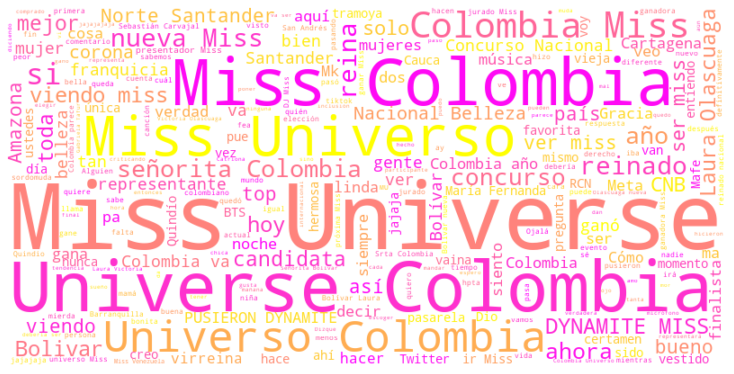

In [35]:
palabras = data.clean.str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400,
                     max_font_size=150, max_words=250,
                     background_color='white', colormap='spring',
                     stopwords=stopwords).generate(palabras) # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Departamentos

In [36]:
deptos = ['Amazonas',
'Antioquia',
'Arauca',
'Atlántico',
'Bogotá',
'Bolivar',
'Boyacá',
'Caldas',
'Caqueta',
'Cartagena',
'Casanare',
'Cauca',
'Cesar',
'Choco',
'Córdoba',
'Cundinamarca',
'Guaviare',
'Huila',
'Guajira',
'Magdalena',
'Meta',
'Nariño',
'Norte',
'Putumayo',
'Quindio',
'Risaralda',
'Santander',
'Tolima',
'Valle',
'Vichada'
]

In [39]:
import unidecode
deptos_norm = [unidecode.unidecode(d.lower()) for d in deptos]

In [40]:
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([unidecode.unidecode(palabra.lower()) for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

In [41]:
data['clean2'] = data.clean.apply(lambda r: pre_procesado(r))

In [42]:
all_text = data.clean2.str.cat(sep=' ')

In [43]:
def count_occurrences(word, sentence):
    return sentence.split().count(word)

dept_cnt = {}
for d in deptos_norm:
    dept_cnt[d] = count_occurrences(d, all_text)

In [44]:
dept_cnt['santander'] = dept_cnt['santander']-dept_cnt['norte']

In [45]:
dept_cnt = {k: v for k, v in sorted(dept_cnt.items(), key=lambda item: item[1], reverse=True)}

In [46]:
trace = go.Bar(x=list(dept_cnt.keys()),
               y=list(dept_cnt.values()),
               marker=dict(color='pink'))

layout = go.Layout(title='Candidatas más mencionadas')

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [47]:
pio.write_html(fig, file='Plot4.html', auto_open=False)